In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import plot as plot
import PcmPy as pcm
from get_utils import get_Gweights
import matplotlib.pyplot as plt

#%matplotlib qt
#%matplotlib widget
%matplotlib inline

In [2]:
# read files 
folder_name = 'Sim_all_inv'

model_name = 'model00'

phase = {'growing_up':[0],'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['GU','NF1','FF1','NF2','FF2']
titles = ['weight_ih','bias_ih','weight_hh','bias_hh','weight_fc','bias_fc','h0']

G, rdm = get_Gweights(folder_name,model_name,phase)

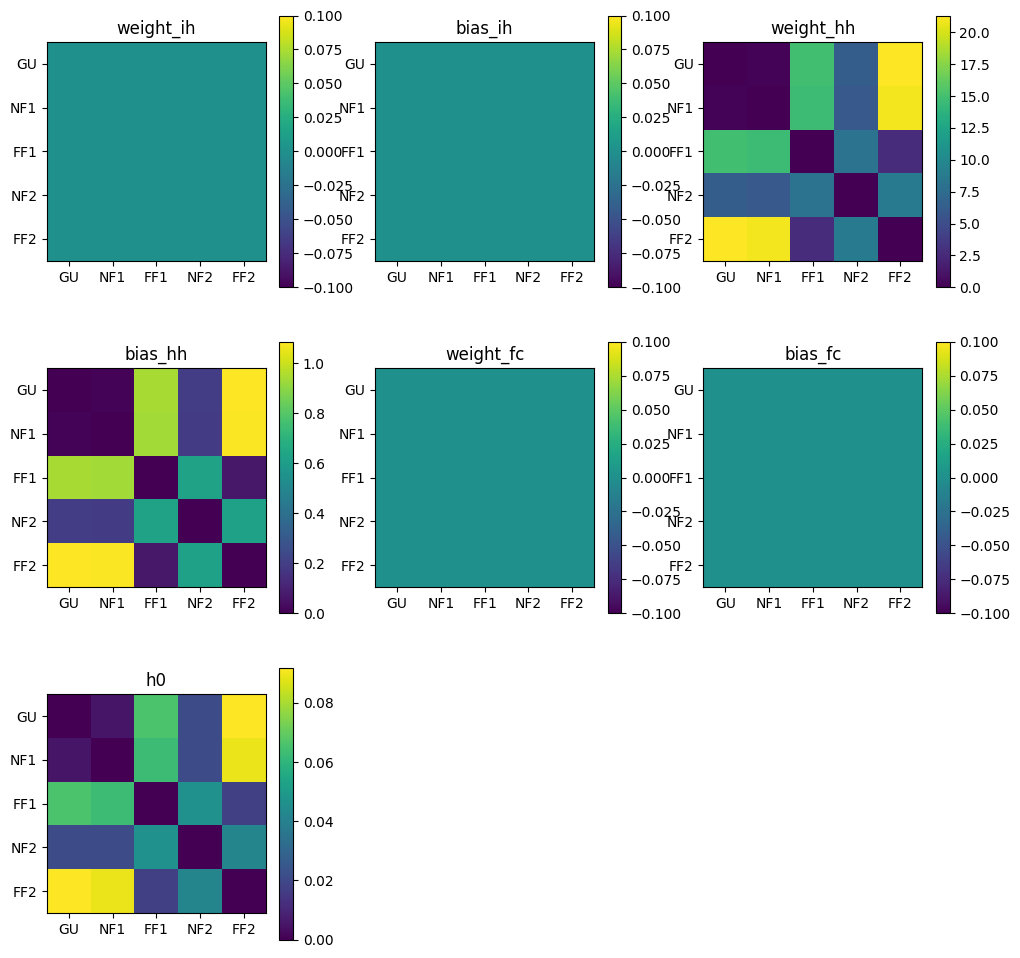

In [3]:
plot.plot_Gs(rdm,labels=labels,titles=titles,vmin=0)

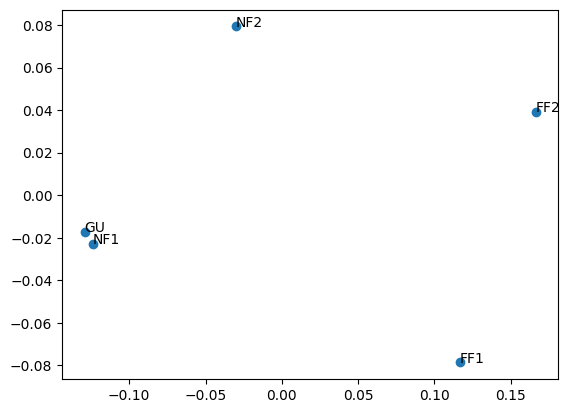

In [4]:
# calculate mds
W,Glam = pcm.classical_mds(G[6])
plt.scatter(W[:,0],W[:,1])
for i, label in enumerate(labels):
    plt.annotate(label, (W[i, 0], W[i, 1]))